# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [2]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [126]:
sales = graphlab.SFrame('kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [127]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

In [128]:
sales.head(1)

Columns:
	id	str
	date	datetime
	price	float
	bedrooms	float
	bathrooms	float
	sqft_living	float
	sqft_lot	int
	floors	float
	waterfront	int
	view	int
	condition	int
	grade	int
	sqft_above	int
	sqft_basement	int
	yr_built	int
	yr_renovated	int
	zipcode	str
	lat	float
	long	float
	sqft_living15	float
	sqft_lot15	float
	sqft_living_sqrt	float
	sqft_lot_sqrt	float
	bedrooms_square	float
	floors_square	float

Rows: 1

Data:
+------------+---------------------------+----------+----------+-----------+
|     id     |            date           |  price   | bedrooms | bathrooms |
+------------+---------------------------+----------+----------+-----------+
| 7129300520 | 2014-10-13 00:00:00+00:00 | 221900.0 |   3.0    |    1.0    |
+------------+---------------------------+----------+----------+-----------+
+-------------+----------+--------+------------+------+-----------+-------+------------+
| sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above |
+-------------+----------+--------+------------+------+-----------+-------+------------+
|    1180.0   |   5650   |  1.0   |     0      |  0   |     3     |   7   |    1180    |
+-------------+----------+--------+------------+------+-----------+-------+------------+
+---------------+----------+--------------+---------+-------------+
| sqft_basement | yr_built | yr_renovated | zipcode |     lat     |
+---------------+----------+--------------+---------+-------------+
|       0       |   1955   |      0       |  98178  | 47.51123398 |
+---------------+----------+--------------+---------+-------------+
+---------------+---------------+-----+
|      long     | sqft_living15 | ... |
+---------------+---------------+-----+
| -122.25677536 |     1340.0    | ... |
+---------------+---------------+-----+
[1 rows x 25 columns]

In [40]:
type(sales), len(sales)

(graphlab.data_structures.sframe.SFrame, 21613)

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [129]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [130]:
model_all_2 = fit_a_model(sales, all_features, 1e10)
model_all_2['coefficients']['value'].nnz()

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 0.602975     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 0.653584     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 0.709806     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 0.763875     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 0.828112     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 0.886225     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

L1_PENALTY: 10000000000.0
Len DATA: 21613
Len FEATURES: 17


6

In [131]:
print_coefficients(model_all_2)

Learned polynomial for degree 17:
       14         13         5         4        3
20.02 x  + 842.1 x  + 350.1 x + 24.42 x + 8469 x + 2.749e+05


In [158]:
print all_features[13],'|  |',all_features[12],'|  |',all_features[4],'|  |',all_features[3],'|  |',all_features[2],

sqft_above |  | grade |  | sqft_living_sqrt |  | sqft_living |  | bathrooms


In [133]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 0.605814     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 0.655479     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 0.704339     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 0.760138     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 0.813329     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 0.871766     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [134]:
print_coefficients(model_all)

Learned polynomial for degree 17:
       14         13         5         4        3
20.02 x  + 842.1 x  + 350.1 x + 24.42 x + 8469 x + 2.749e+05


Find what features had non-zero weight.

In [100]:
model_all['coefficients']['value'].nnz()

1

In [18]:
import numpy as np

In [21]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1

    # Get learned parameters as a list
    w = list(model.coefficients['value'])

    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print 'Learned polynomial for degree ' + str(deg) + ':'
    w.reverse()
    print np.poly1d(w)

In [101]:
print_coefficients(model_all)

Learned polynomial for degree 17:
 
5.401e+05


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [140]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [147]:
def fit_a_model(DATA, FEATURES, L1_PENALTY):
    print 'L1_PENALTY:',L1_PENALTY
    print 'Len DATA:',len(DATA)
    print 'Len FEATURES:',len(FEATURES)
    model = graphlab.linear_regression.create(DATA, target='price', features=FEATURES,
                                              validation_set=None, #verbose=False,
                                              l2_penalty=0., l1_penalty=L1_PENALTY,
                                              solver='fista')
    return model



In [43]:
def get_residual_sum_of_squares(model, data, outcome):
    # First get the predictions    
    predictions = model.predict(data)
    #print 'La len de predictions es:',len(predictions)
    # Then compute the residuals/errors
    residual = outcome - predictions
    #print 'La len de residual es:',len(residual)
    # Then square and add them up
    RSS = sum(residual*residual)
    
    return RSS    

In [42]:
len(training),len(validation)

(9761, 9635)

In [55]:
import pandas as pd
L1=[]
RSSs=[]
l1_penalty = np.logspace(1, 7, num=13)
for i in l1_penalty:
    model = fit_a_model(training, all_features, i)
    L1.append(i)
    rss = get_residual_sum_of_squares(model,validation,validation['price'])
    RSSs.append(rss)
    print 'L1 is',i,'y RSS:',rss
df = pd.DataFrame({'L1':L1, 'RSSs':RSSs})

L1_PENALTY: 10.0
Len DATA: 9761
Len FEATURES: 17
L1 is 10.0 y RSS: 6.25766285142e+14
L1_PENALTY: 31.6227766017
Len DATA: 9761
Len FEATURES: 17
L1 is 31.6227766017 y RSS: 6.25766285362e+14
L1_PENALTY: 100.0
Len DATA: 9761
Len FEATURES: 17
L1 is 100.0 y RSS: 6.25766286058e+14
L1_PENALTY: 316.227766017
Len DATA: 9761
Len FEATURES: 17
L1 is 316.227766017 y RSS: 6.25766288257e+14
L1_PENALTY: 1000.0
Len DATA: 9761
Len FEATURES: 17
L1 is 1000.0 y RSS: 6.25766295212e+14
L1_PENALTY: 3162.27766017
Len DATA: 9761
Len FEATURES: 17
L1 is 3162.27766017 y RSS: 6.25766317206e+14
L1_PENALTY: 10000.0
Len DATA: 9761
Len FEATURES: 17
L1 is 10000.0 y RSS: 6.25766386761e+14
L1_PENALTY: 31622.7766017
Len DATA: 9761
Len FEATURES: 17
L1 is 31622.7766017 y RSS: 6.25766606749e+14
L1_PENALTY: 100000.0
Len DATA: 9761
Len FEATURES: 17
L1 is 100000.0 y RSS: 6.25767302792e+14
L1_PENALTY: 316227.766017
Len DATA: 9761
Len FEATURES: 17
L1 is 316227.766017 y RSS: 6.25769507644e+14
L1_PENALTY: 1000000.0
Len DATA: 9761
Len

In [56]:
df

,L1,RSSs
0,10.000000,6.257663e+14
1,31.622777,6.257663e+14
2,100.000000,6.257663e+14
3,316.227766,6.257663e+14
4,1000.000000,6.257663e+14
5,3162.277660,6.257663e+14
6,10000.000000,6.257664e+14
7,31622.776602,6.257666e+14
8,100000.000000,6.257673e+14
9,316227.766017,6.257695e+14


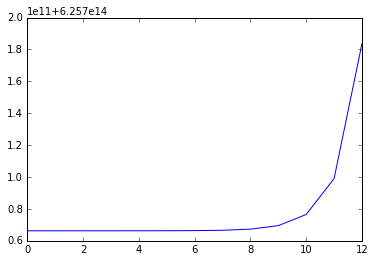

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
df['RSSs'].plot()

In [35]:
for i,j in zip(df['RSSs'],df['L1']):
    if i == min(RSSs):
               print 'The lowest RSS is reached by L1 =',j,'with a value of:',i
        

The lowest RSS is reached by L1 = 10.0 with a value of: 6.25766285142e+14


*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?

10.0
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

6.25766285142e+14

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

18

In [61]:
model_L1_10 = fit_a_model(training, all_features, 10)

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.441145     | 6287414.310279     | 322429.554621 |

| 2         | 3        | 0.000003  | 0.482694     | 6004129.870008     | 303352.364502 |

| 3         | 4        | 0.000003  | 0.522548     | 5888882.499599     | 298370.510858 |

| 4         | 5        | 0.000003  | 0.563702     | 5813781.207975     | 293774.670687 |

| 5         | 6        | 0.000003  | 0.603782     | 5737572.318059     | 289374.784200 |

| 6         | 7        | 0.000003  | 0.644896     | 5655864.782013     | 285354.826809 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

In [59]:
print_coefficients(model_L1_10)

Learned polynomial for degree 17:
       17         16         15         14        13        12
56.07 x  + 9.434 x  + 122.4 x  + 43.29 x  + 6207 x  + 6609 x 
              11             10             9            8         7
 + 9.331e+04 x  + 6.019e+05 x  + 1.292e+04 x + 2.12e+04 x + 148.3 x
             6        5         4             3       2
 + 0.003484 x + 1125 x + 39.12 x + 2.541e+04 x + 937 x + 7937 x + 1.899e+04


# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [62]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [68]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [66]:
L1s=[]
RSSs=[]
num_nnz_coef=[] # number of non zero coeffs.
for i in l1_penalty_values:
    model =  fit_a_model(training, all_features, i)
    L1s.append(i)
    num_nnz_coef.append(model['coefficients']['value'].nnz())
    rss = get_residual_sum_of_squares(model,validation,validation['price'])
    RSSs.append(rss)
df2 = pd.DataFrame({'L1s':L1s,'num_nnz_coef':num_nnz_coef,'RSS':RSSs})

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.465700     | 6302596.887972     | 323993.114447 |

| 2         | 3        | 0.000003  | 0.504926     | 6023837.209073     | 303975.326597 |

| 3         | 4        | 0.000003  | 0.544989     | 5911895.809122     | 298805.600064 |

| 4         | 5        | 0.000003  | 0.586329     | 5839957.243889     | 294292.598204 |

| 5         | 6        | 0.000003  | 0.627662     | 5767046.162784     | 289966.959726 |

| 6         | 7        | 0.000003  | 0.667797     | 5688716.875912     | 285965.139010 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

L1_PENALTY: 100000000.0
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.432038     | 6306761.089277     | 324431.811110 |

| 2         | 3        | 0.000003  | 0.473152     | 6029242.439247     | 304162.702383 |

| 3         | 4        | 0.000003  | 0.512297     | 5918207.784303     | 298943.962355 |

| 4         | 5        | 0.000003  | 0.554888     | 5847136.675810     | 294455.684490 |

| 5         | 6        | 0.000003  | 0.593014     | 5775130.101176     | 290153.028407 |

| 6         | 7        | 0.000003  | 0.635763     | 5697727.383553     | 286159.539614 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 127427498.57
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.454310     | 6312067.428647     | 324996.927681 |

| 2         | 3        | 0.000003  | 0.493374     | 6036130.191201     | 304411.734396 |

| 3         | 4        | 0.000003  | 0.531323     | 5926250.979130     | 299132.112018 |

| 4         | 5        | 0.000003  | 0.571350     | 5856285.249441     | 294676.578872 |

| 5         | 6        | 0.000003  | 0.617104     | 5785431.265169     | 290404.829180 |

| 6         | 7        | 0.000003  | 0.657457     | 5709209.251967     | 286424.040727 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 162377673.919
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.414278     | 6318829.161558     | 325726.887556 |

| 2         | 3        | 0.000003  | 0.450324     | 6044907.077830     | 304745.693519 |

| 3         | 4        | 0.000003  | 0.486112     | 5936500.217141     | 299391.051314 |

| 4         | 5        | 0.000003  | 0.520625     | 5867943.043467     | 294979.244899 |

| 5         | 6        | 0.000003  | 0.557693     | 5798557.775695     | 290749.495050 |

| 6         | 7        | 0.000003  | 0.593141     | 5723840.304020     | 286788.259115 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 206913808.111
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.407602     | 6327445.469597     | 326672.935878 |

| 2         | 3        | 0.000003  | 0.445729     | 6056091.246122     | 305198.151982 |

| 3         | 4        | 0.000003  | 0.479180     | 5949560.566172     | 299752.080188 |

| 4         | 5        | 0.000003  | 0.516856     | 5882798.280387     | 295399.217084 |

| 5         | 6        | 0.000003  | 0.555471     | 5815284.561515     | 291227.202999 |

| 6         | 7        | 0.000003  | 0.591702     | 5742484.289679     | 287296.320924 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 263665089.873
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.439909     | 6338425.015323     | 327904.016823 |

| 2         | 3        | 0.000003  | 0.478072     | 6070342.951911     | 305818.193076 |

| 3         | 4        | 0.000003  | 0.514158     | 5966203.042130     | 300262.391571 |

| 4         | 5        | 0.000003  | 0.551295     | 5901727.937067     | 295989.815933 |

| 5         | 6        | 0.000003  | 0.600861     | 5836599.086125     | 291898.147485 |

| 6         | 7        | 0.000003  | 0.638942     | 5766241.854070     | 288014.702465 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 335981828.628
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.402410     | 6352415.978265     | 329513.773176 |

| 2         | 3        | 0.000003  | 0.438068     | 6088503.547309     | 306678.464467 |

| 3         | 4        | 0.000003  | 0.474029     | 5987410.136686     | 300993.852916 |

| 4         | 5        | 0.000003  | 0.510100     | 5925849.529320     | 296831.866711 |

| 5         | 6        | 0.000003  | 0.544922     | 5863759.656463     | 292853.418793 |

| 6         | 7        | 0.000003  | 0.580623     | 5796515.529440     | 289044.471466 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 428133239.872
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.396773     | 6370244.310167     | 331630.660676 |

| 2         | 3        | 0.000003  | 0.432005     | 6111645.136891     | 307887.639691 |

| 3         | 4        | 0.000003  | 0.467784     | 6014433.803461     | 302056.769305 |

| 4         | 5        | 0.000003  | 0.503724     | 5956587.067149     | 298048.868696 |

| 5         | 6        | 0.000003  | 0.540047     | 5898369.687568     | 294231.926395 |

| 6         | 7        | 0.000003  | 0.575827     | 5835068.031486     | 290539.467795 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 545559478.117
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.422164     | 6392962.501428     | 334432.629813 |

| 2         | 3        | 0.000003  | 0.458916     | 6141133.877684     | 309609.652192 |

| 3         | 4        | 0.000003  | 0.496030     | 6048869.376781     | 303621.347701 |

| 4         | 5        | 0.000003  | 0.531343     | 5995755.132177     | 299830.533427 |

| 5         | 6        | 0.000003  | 0.567634     | 5942472.372582     | 296246.537804 |

| 6         | 7        | 0.000003  | 0.604982     | 5882772.472167     | 292655.514067 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 695192796.178
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.397120     | 6421911.739799     | 338168.430249 |

| 2         | 3        | 0.000003  | 0.432055     | 6178710.662590     | 312093.147503 |

| 3         | 4        | 0.000003  | 0.467538     | 6092749.790017     | 305950.822078 |

| 4         | 5        | 0.000003  | 0.503309     | 6045666.044451     | 302468.872046 |

| 5         | 6        | 0.000003  | 0.539542     | 5998277.020726     | 299195.437483 |

| 6         | 7        | 0.000003  | 0.576699     | 5944444.613403     | 295775.972512 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 885866790.41
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.397691     | 6458801.015264     | 343188.313914 |

| 2         | 3        | 0.000003  | 0.434172     | 6226593.800368     | 315715.881133 |

| 3         | 4        | 0.000003  | 0.470398     | 6148665.480461     | 309451.624488 |

| 4         | 5        | 0.000003  | 0.506455     | 6109266.245878     | 306412.359795 |

| 5         | 6        | 0.000003  | 0.542679     | 6067941.501592     | 303417.317296 |

| 6         | 7        | 0.000003  | 0.579759     | 6019163.317913     | 300393.085687 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 1128837891.68
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.394695     | 6505808.107267     | 349987.699359 |

| 2         | 3        | 0.000003  | 0.430095     | 6287610.099403     | 321049.939717 |

| 3         | 4        | 0.000003  | 0.465902     | 6219917.462832     | 314747.103160 |

| 4         | 5        | 0.000003  | 0.501612     | 6186864.205766     | 312133.200443 |

| 5         | 6        | 0.000003  | 0.537528     | 6141049.702542     | 309268.413008 |

| 6         | 7        | 0.000003  | 0.573125     | 6098090.379557     | 306911.599029 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 1438449888.29
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.395849     | 6565708.060916     | 359267.674436 |

| 2         | 3        | 0.000003  | 0.431314     | 6365361.632804     | 328953.510730 |

| 3         | 4        | 0.000003  | 0.467788     | 6305829.246141     | 322613.170450 |

| 4         | 5        | 0.000003  | 0.504648     | 6265428.838674     | 319852.473118 |

| 5         | 6        | 0.000003  | 0.540660     | 6233853.106449     | 318320.600901 |

| 6         | 7        | 0.000003  | 0.576324     | 6199198.857716     | 316732.370565 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 1832980710.83
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.393432     | 6642037.071382     | 372015.681824 |

| 2         | 3        | 0.000003  | 0.428042     | 6461738.956416     | 340588.423328 |

| 3         | 4        | 0.000003  | 0.464013     | 6398392.723924     | 333431.863633 |

| 4         | 5        | 0.000003  | 0.501057     | 6371877.122886     | 331286.359425 |

| 5         | 6        | 0.000003  | 0.533977     | 6353136.654069     | 330421.269864 |

| 6         | 7        | 0.000003  | 0.570635     | 6330612.934807     | 329296.764297 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 2335721469.09
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.416070     | 6739301.231007     | 389607.085142 |

| 2         | 3        | 0.000003  | 0.452950     | 6569297.382654     | 356355.616933 |

| 3         | 4        | 0.000003  | 0.491022     | 6519180.189446     | 348232.602946 |

| 4         | 5        | 0.000003  | 0.527831     | 6511771.934086     | 347519.257327 |

| 5         | 6        | 0.000003  | 0.564736     | 6508236.398022     | 347641.774942 |

| 6         | 7        | 0.000003  | 0.602599     | 6496515.714757     | 346711.084406 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 2976351441.63
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.427681     | 6851251.348758     | 412576.866347 |

| 2         | 3        | 0.000003  | 0.467103     | 6705927.418436     | 378624.562082 |

| 3         | 4        | 0.000003  | 0.504171     | 6678759.248861     | 371401.977561 |

| 4         | 5        | 0.000003  | 0.539544     | 6689839.793283     | 371772.510021 |

| 5         | 6        | 0.000003  | 0.574671     | 6700050.222874     | 372113.713871 |

| 6         | 7        | 0.000003  | 0.613950     | 6697293.370032     | 370685.051067 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3792690190.73
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.411819     | 6990727.771524     | 443765.694135 |

| 2         | 3        | 0.000003  | 0.451646     | 6881811.580352     | 411414.484829 |

| 3         | 4        | 0.000003  | 0.494387     | 6872119.637764     | 404347.406375 |

| 4         | 5        | 0.000003  | 0.537642     | 6884564.579949     | 402804.042129 |

| 5         | 6        | 0.000003  | 0.575785     | 6884279.257633     | 400745.316819 |

| 6         | 7        | 0.000003  | 0.612018     | 6869773.133183     | 397237.306904 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 4832930238.57
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.404169     | 7165064.642471     | 485718.879258 |

| 2         | 3        | 0.000003  | 0.440423     | 7086725.698544     | 456087.127286 |

| 3         | 4        | 0.000003  | 0.485801     | 7075577.209652     | 446853.928812 |

| 4         | 5        | 0.000003  | 0.521658     | 7062536.185828     | 441456.188174 |

| 5         | 6        | 0.000003  | 0.557366     | 7054349.178409     | 436331.029744 |

| 6         | 7        | 0.000003  | 0.597304     | 7053909.066828     | 430723.907200 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 6158482110.66
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000005  | 0.425682     | 7202439.442101     | 484432.625377 |

| 2         | 3        | 0.000005  | 0.466133     | 7284840.298565     | 505076.954827 |

| 3         | 4        | 0.000005  | 0.506277     | 7266438.445660     | 490990.237855 |

| 4         | 5        | 0.000005  | 0.547802     | 7270633.139688     | 473802.625159 |

| 5         | 6        | 0.000005  | 0.587751     | 7320904.689497     | 462020.358653 |

| 6         | 7        | 0.000005  | 0.636910     | 7344719.665332     | 441190.123985 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 7847599703.51
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000012  | 0.428370     | 7228843.829153     | 476257.577720 |

| 2         | 3        | 0.000012  | 0.464075     | 7504641.811821     | 514487.205685 |

| 3         | 4        | 0.000012  | 0.502862     | 7402647.878877     | 451928.315910 |

| 4         | 5        | 0.000012  | 0.539872     | 7312309.081776     | 409957.463247 |

| 5         | 6        | 0.000012  | 0.578561     | 7239807.218168     | 388380.843122 |

| 6         | 7        | 0.000012  | 0.614021     | 7187431.218291     | 380705.223778 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 10000000000.0
Len DATA: 9761
Len FEATURES: 17


In [67]:
df2

,L1s,RSS,num_nnz_coef
0,1.000000e+08,6.274927e+14,18
1,1.274275e+08,6.282105e+14,18
2,1.623777e+08,6.291767e+14,18
3,2.069138e+08,6.306501e+14,18
4,2.636651e+08,6.329402e+14,17
5,3.359818e+08,6.362681e+14,17
6,4.281332e+08,6.412612e+14,17
7,5.455595e+08,6.489835e+14,17
8,6.951928e+08,6.609622e+14,17
9,8.858668e+08,6.772615e+14,16


In [71]:
largest_max_nonzero_df2 = df2[df2['num_nnz_coef']>max_nonzeros] #largest l1_penalty that has more non-zeros than max_nonzero 
smallest_max_nonzero_df2 = df2[df2['num_nnz_coef']<max_nonzeros] #The smallest l1_penalty that has fewer non-zeros than max_nonzero 

In [73]:
L1s_min=[]
for i in smallest_max_nonzero_df2.L1s:
    L1s_min.append(i)
print min(L1s_min)

3792690190.73


In [74]:
def get_largest_and_lowest_L1(df):
    largest_max_nonzero_df2 = df[df['num_nnz_coef']>max_nonzeros]
    smallest_max_nonzero_df2 = df[df['num_nnz_coef']<max_nonzeros]
    largest=[]
    smallest=[]
    
    for i in largest_max_nonzero_df2['L1s']:
        largest.append(i)
    for i in smallest_max_nonzero_df2['L1s']:
        smallest.append(i)
    
    return max(largest),min(smallest)
    

In [75]:
l1_penalty_min,l1_penalty_max = get_largest_and_lowest_L1(df2)
print l1_penalty_min,l1_penalty_max

2976351441.63 3792690190.73


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [76]:
l1_penalty_min = 2976351441.63
l1_penalty_max = 3792690190.73

***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

l1_penalty_min = 2976351442


l1_penalty_max = 3792690191

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [78]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

Sparcity = 7

In [112]:
L1=[]
RSSs=[]
num_nnz_coef=[] # number of non zero coeffs.
for i in l1_penalty_values:
    model = fit_a_model(training, all_features, i)
    L1.append(i)
    RSSs.append(get_residual_sum_of_squares(model,validation,validation['price']))
    num_nnz_coef.append(model['coefficients']['value'].nnz())
    
df = pd.DataFrame({'L1':L1, 'RSSs':RSSs, 'num_nnz_coef':num_nnz_coef})

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.434569     | 6739301.231007     | 389607.085142 |

| 2         | 3        | 0.000003  | 0.473082     | 6569297.382654     | 356355.616933 |

| 3         | 4        | 0.000003  | 0.511234     | 6519180.189446     | 348232.602946 |

| 4         | 5        | 0.000003  | 0.552276     | 6511771.934086     | 347519.257327 |

| 5         | 6        | 0.000003  | 0.594199     | 6508236.398022     | 347641.774942 |

| 6         | 7        | 0.000003  | 0.641683     | 6496515.714757     | 346711.084406 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

L1_PENALTY: 2976351441.63
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.461929     | 6745824.463817     | 390816.789246 |

| 2         | 3        | 0.000003  | 0.497907     | 6576394.847047     | 357433.566852 |

| 3         | 4        | 0.000003  | 0.539713     | 6527572.935664     | 349357.366319 |

| 4         | 5        | 0.000003  | 0.582038     | 6521142.806632     | 348701.019139 |

| 5         | 6        | 0.000003  | 0.626215     | 6518614.014289     | 348888.199260 |

| 6         | 7        | 0.000003  | 0.668404     | 6507128.891315     | 347885.665556 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3019316638.95
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.457441     | 6752347.657761     | 392009.121753 |

| 2         | 3        | 0.000003  | 0.494953     | 6583521.070903     | 358524.867897 |

| 3         | 4        | 0.000003  | 0.535246     | 6535971.427822     | 350493.642380 |

| 4         | 5        | 0.000003  | 0.576099     | 6530517.602470     | 349894.204388 |

| 5         | 6        | 0.000003  | 0.620179     | 6528996.173933     | 350146.209214 |

| 6         | 7        | 0.000003  | 0.661549     | 6517746.461337     | 349069.317383 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3062281836.27
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.438077     | 6758338.328596     | 393183.638571 |

| 2         | 3        | 0.000003  | 0.478066     | 6590703.295167     | 359634.836047 |

| 3         | 4        | 0.000003  | 0.523053     | 6544370.536454     | 351640.727736 |

| 4         | 5        | 0.000003  | 0.562936     | 6539890.228171     | 351097.892318 |

| 5         | 6        | 0.000003  | 0.609106     | 6539379.516775     | 351415.297011 |

| 6         | 7        | 0.000003  | 0.649991     | 6528366.248329     | 350261.721339 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3105247033.59
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.466153     | 6764145.398843     | 394355.637359 |

| 2         | 3        | 0.000003  | 0.510094     | 6597904.810916     | 360757.199941 |

| 3         | 4        | 0.000003  | 0.567844     | 6552769.840363     | 352798.630865 |

| 4         | 5        | 0.000003  | 0.624795     | 6549262.086461     | 352312.355494 |

| 5         | 6        | 0.000003  | 0.670142     | 6549763.246198     | 352695.353562 |

| 6         | 7        | 0.000003  | 0.717402     | 6538986.777810     | 351462.667919 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3148212230.91
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.482290     | 6769952.469091     | 395533.206039 |

| 2         | 3        | 0.000003  | 0.521208     | 6605106.326666     | 361888.548761 |

| 3         | 4        | 0.000003  | 0.564453     | 6561169.144272     | 353967.313247 |

| 4         | 5        | 0.000003  | 0.608395     | 6558633.944750     | 353537.695247 |

| 5         | 6        | 0.000003  | 0.651745     | 6560146.975621     | 353986.270792 |

| 6         | 7        | 0.000003  | 0.693248     | 6549607.307292     | 352672.009019 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3191177428.24
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.459261     | 6775759.539339     | 396716.295011 |

| 2         | 3        | 0.000003  | 0.515436     | 6612307.842416     | 363028.798505 |

| 3         | 4        | 0.000003  | 0.573260     | 6569568.448181     | 355146.668469 |

| 4         | 5        | 0.000003  | 0.661339     | 6568005.803040     | 354773.798877 |

| 5         | 6        | 0.000003  | 0.825452     | 6570530.705045     | 355287.930317 |

| 6         | 7        | 0.000003  | 0.909529     | 6560227.836773     | 353889.658579 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3234142625.56
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.556843     | 6781566.574986     | 397904.847937 |

| 2         | 3        | 0.000003  | 0.596947     | 6619509.315257     | 364177.858692 |

| 3         | 4        | 0.000003  | 0.641927     | 6577967.702044     | 356336.583438 |

| 4         | 5        | 0.000003  | 0.679421     | 6577377.605489     | 356020.546809 |

| 5         | 6        | 0.000003  | 0.723207     | 6580914.372598     | 356600.206652 |

| 6         | 7        | 0.000003  | 0.781317     | 6570848.302974     | 355115.523804 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3277107822.88
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.459988     | 6787373.645234     | 399098.830100 |

| 2         | 3        | 0.000003  | 0.500175     | 6626710.831006     | 365335.659819 |

| 3         | 4        | 0.000003  | 0.538969     | 6586367.005953     | 357536.966832 |

| 4         | 5        | 0.000003  | 0.582961     | 6586749.463778     | 357277.842388 |

| 5         | 6        | 0.000003  | 0.620710     | 6591298.102022     | 357922.998572 |

| 6         | 7        | 0.000003  | 0.659588     | 6581468.832455     | 356349.534440 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3320073020.2
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.459178     | 6793180.715481     | 400298.185918 |

| 2         | 3        | 0.000003  | 0.499036     | 6633912.346756     | 366502.112290 |

| 3         | 4        | 0.000003  | 0.538524     | 6594766.309862     | 358747.706580 |

| 4         | 5        | 0.000003  | 0.579009     | 6596121.322068     | 358545.567335 |

| 5         | 6        | 0.000003  | 0.612203     | 6601681.831445     | 359256.182222 |

| 6         | 7        | 0.000003  | 0.649983     | 6592089.361936     | 357591.598955 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3363038217.52
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.435623     | 6798987.785729     | 401502.867233 |

| 2         | 3        | 0.000003  | 0.480932     | 6641113.862506     | 367677.133766 |

| 3         | 4        | 0.000003  | 0.527559     | 6603165.613771     | 359968.698182 |

| 4         | 5        | 0.000003  | 0.571959     | 6605493.180357     | 359823.611417 |

| 5         | 6        | 0.000003  | 0.613001     | 6612065.560868     | 360599.642341 |

| 6         | 7        | 0.000003  | 0.656481     | 6602709.891417     | 358841.633718 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3406003414.84
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.425152     | 6804794.855977     | 402712.826253 |

| 2         | 3        | 0.000003  | 0.461818     | 6648315.378256     | 368860.642357 |

| 3         | 4        | 0.000003  | 0.505548     | 6611564.917680     | 361199.837673 |

| 4         | 5        | 0.000003  | 0.541531     | 6614865.038647     | 361111.865068 |

| 5         | 6        | 0.000003  | 0.579622     | 6622449.290291     | 361953.264500 |

| 6         | 7        | 0.000003  | 0.618435     | 6613330.420898     | 360099.555727 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3448968612.16
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.422883     | 6810601.891624     | 403928.008294 |

| 2         | 3        | 0.000003  | 0.459883     | 6655516.851097     | 370052.549506 |

| 3         | 4        | 0.000003  | 0.496924     | 6619964.171543     | 362441.014218 |

| 4         | 5        | 0.000003  | 0.534934     | 6624236.841096     | 362410.211648 |

| 5         | 6        | 0.000003  | 0.571922     | 6632388.356592     | 363238.633808 |

| 6         | 7        | 0.000003  | 0.609727     | 6624497.937274     | 361462.325873 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3491933809.48
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.416545     | 6816408.961872     | 405148.380776 |

| 2         | 3        | 0.000003  | 0.453828     | 6662718.366846     | 371252.788456 |

| 3         | 4        | 0.000003  | 0.490977     | 6628363.475452     | 363692.139769 |

| 4         | 5        | 0.000003  | 0.528653     | 6633608.699386     | 363718.558461 |

| 5         | 6        | 0.000003  | 0.570384     | 6642054.345717     | 364484.037875 |

| 6         | 7        | 0.000003  | 0.608997     | 6636001.595070     | 362894.485099 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3534899006.8
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.423486     | 6822216.032119     | 406373.889776 |

| 2         | 3        | 0.000003  | 0.473960     | 6669919.882596     | 372461.271652 |

| 3         | 4        | 0.000003  | 0.513480     | 6636762.779361     | 364953.104716 |

| 4         | 5        | 0.000003  | 0.551299     | 6642980.557675     | 365036.790356 |

| 5         | 6        | 0.000003  | 0.590631     | 6651720.334842     | 365737.059513 |

| 6         | 7        | 0.000003  | 0.627395     | 6647505.252865     | 364336.765726 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3577864204.12
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.427857     | 6828023.102367     | 407604.488964 |

| 2         | 3        | 0.000003  | 0.467718     | 6677121.398346     | 373677.919108 |

| 3         | 4        | 0.000003  | 0.508301     | 6645162.083270     | 366223.807423 |

| 4         | 5        | 0.000003  | 0.544827     | 6652352.415965     | 366364.800631 |

| 5         | 6        | 0.000003  | 0.578649     | 6661386.323967     | 366997.620697 |

| 6         | 7        | 0.000003  | 0.628160     | 6659008.910661     | 365789.048032 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3620829401.45
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.415805     | 6833830.172615     | 408840.132375 |

| 2         | 3        | 0.000003  | 0.455279     | 6684322.914096     | 374902.651339 |

| 3         | 4        | 0.000003  | 0.492696     | 6653561.387179     | 367504.146882 |

| 4         | 5        | 0.000003  | 0.530864     | 6661724.274254     | 367702.483336 |

| 5         | 6        | 0.000003  | 0.571048     | 6671052.313092     | 368265.644004 |

| 6         | 7        | 0.000003  | 0.609771     | 6670512.568457     | 367251.213363 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3663794598.77
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.428528     | 6839637.208262     | 410080.767006 |

| 2         | 3        | 0.000003  | 0.468556     | 6691524.386936     | 376135.382003 |

| 3         | 4        | 0.000003  | 0.507037     | 6661960.641043     | 368794.015010 |

| 4         | 5        | 0.000003  | 0.541837     | 6671096.076703     | 369049.725239 |

| 5         | 6        | 0.000003  | 0.587182     | 6680718.244624     | 369541.044998 |

| 6         | 7        | 0.000003  | 0.625080     | 6679542.716608     | 368401.661442 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3706759796.09
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.419147     | 6845444.278510     | 411326.362411 |

| 2         | 3        | 0.000003  | 0.454791     | 6698725.902686     | 377376.047334 |

| 3         | 4        | 0.000003  | 0.490978     | 6670359.944952     | 370093.327468 |

| 4         | 5        | 0.000003  | 0.526720     | 6680467.934993     | 370406.438000 |

| 5         | 6        | 0.000003  | 0.563905     | 6690384.233749     | 370823.762675 |

| 6         | 7        | 0.000003  | 0.600120     | 6688418.043320     | 369539.610571 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3749724993.41
Len DATA: 9761
Len FEATURES: 17
L1_PENALTY:

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.408041     | 6851251.348758     | 412576.866347 |

| 2         | 3        | 0.000003  | 0.443219     | 6705927.418436     | 378624.562082 |

| 3         | 4        | 0.000003  | 0.477355     | 6678759.248861     | 371401.977561 |

| 4         | 5        | 0.000003  | 0.513228     | 6689839.793283     | 371772.510021 |

| 5         | 6        | 0.000003  | 0.549153     | 6700050.222874     | 372113.713871 |

| 6         | 7        | 0.000003  | 0.584409     | 6697293.370032     | 370685.051067 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

 3792690190.73
Len DATA: 9761
Len FEATURES: 17


In [113]:
df

,L1,RSSs,num_nnz_coef
0,2.976351e+09,9.669257e+14,10
1,3.019317e+09,9.740195e+14,10
2,3.062282e+09,9.811884e+14,10
3,3.105247e+09,9.893283e+14,10
4,3.148212e+09,9.987832e+14,10
5,3.191177e+09,1.008477e+15,10
6,3.234143e+09,1.018299e+15,10
7,3.277108e+09,1.028248e+15,10
8,3.320073e+09,1.034617e+15,8
9,3.363038e+09,1.038555e+15,8


In [114]:
df3 = df[df['num_nnz_coef'] == max_nonzeros]
df3

,L1,RSSs,num_nnz_coef
11,3.448969e+09,1.046937e+15,7
12,3.491934e+09,1.051148e+15,7
13,3.534899e+09,1.055993e+15,7
14,3.577864e+09,1.060800e+15,7


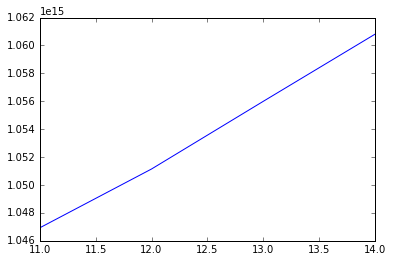

In [115]:
df3.RSSs.plot()


In [116]:
for i in df3.L1:
    print i

3448968612.16
3491933809.48
3534899006.8
3577864204.12


In [93]:
L1[11]

3448968612.1615791

In [148]:
best_model = fit_a_model(training, all_features, L1[11])

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.437587     | 6804794.855977     | 402712.826253 |

| 2         | 3        | 0.000003  | 0.476482     | 6648315.378256     | 368860.642357 |

| 3         | 4        | 0.000003  | 0.520227     | 6611564.917680     | 361199.837673 |

| 4         | 5        | 0.000003  | 0.561301     | 6614865.038647     | 361111.865068 |

| 5         | 6        | 0.000003  | 0.602047     | 6622449.290291     | 361953.264500 |

| 6         | 7        | 0.000003  | 0.642378     | 6613330.420898     | 360099.555727 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

L1_PENALTY: 3448968612.16
Len DATA: 9761
Len FEATURES: 17


In [151]:
print_coefficients(best_model)

Learned polynomial for degree 17:
       14        13         5         4             3
30.01 x  + 2899 x  + 690.1 x + 32.41 x + 1.587e+04 x + 661.7 x + 2.223e+05


In [150]:
len(all_features)

17

In [153]:

print (best_model.coefficients['value']).nnz()

7


In [138]:
print_coefficients(best_model)

Learned polynomial for degree 17:
       14        13         5         4             3
30.01 x  + 2899 x  + 690.1 x + 32.41 x + 1.587e+04 x + 661.7 x + 2.223e+05


In [157]:
print '|  |',all_features[13],'|  |',all_features[12],'|  |',all_features[4],'|  |',all_features[3],'|  |',all_features[2], '| |',all_features[0],

|  | sqft_above |  | grade |  | sqft_living_sqrt |  | sqft_living |  | bathrooms | | bedrooms


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?




2. What features in this model have non-zero coefficients?


sqft_basement |  | sqft_above |  | sqft_lot |  | sqft_living_sqrt |  | sqft_living |  | bedrooms_square

Probamos para L1 = 10

In [152]:
test_model = fit_a_model(training, all_features, 10)

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000003  | 0.454462     | 6287414.310279     | 322429.554621 |

| 2         | 3        | 0.000003  | 0.493226     | 6004129.870008     | 303352.364502 |

| 3         | 4        | 0.000003  | 0.533475     | 5888882.499599     | 298370.510858 |

| 4         | 5        | 0.000003  | 0.573746     | 5813781.207975     | 293774.670687 |

| 5         | 6        | 0.000003  | 0.614397     | 5737572.318059     | 289374.784200 |

| 6         | 7        | 0.000003  | 0.654012     | 5655864.782013     | 285354.826809 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

L1_PENALTY: 10
Len DATA: 9761
Len FEATURES: 17


In [154]:
print (test_model.coefficients['value']).nnz()

18


In [156]:
print_coefficients(test_model)

Learned polynomial for degree 17:
       17         16         15         14        13        12
56.07 x  + 9.434 x  + 122.4 x  + 43.29 x  + 6207 x  + 6609 x 
              11             10             9            8         7
 + 9.331e+04 x  + 6.019e+05 x  + 1.292e+04 x + 2.12e+04 x + 148.3 x
             6        5         4             3       2
 + 0.003484 x + 1125 x + 39.12 x + 2.541e+04 x + 937 x + 7937 x + 1.899e+04
